In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import torch
print(torch.cuda.device_count())      # → 1
print(torch.cuda.get_device_name(0))  # → name of the *second* physical GPU

1
NVIDIA A100-SXM4-40GB


/pscratch/sd/x/xchong/envs/lightly/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


20211222_094342_petiole_test_00100.png
  GT classes: [  0   1   2   3   4   5   6 255]
  Predicted classes: [0 1 2 3 4 5 6]


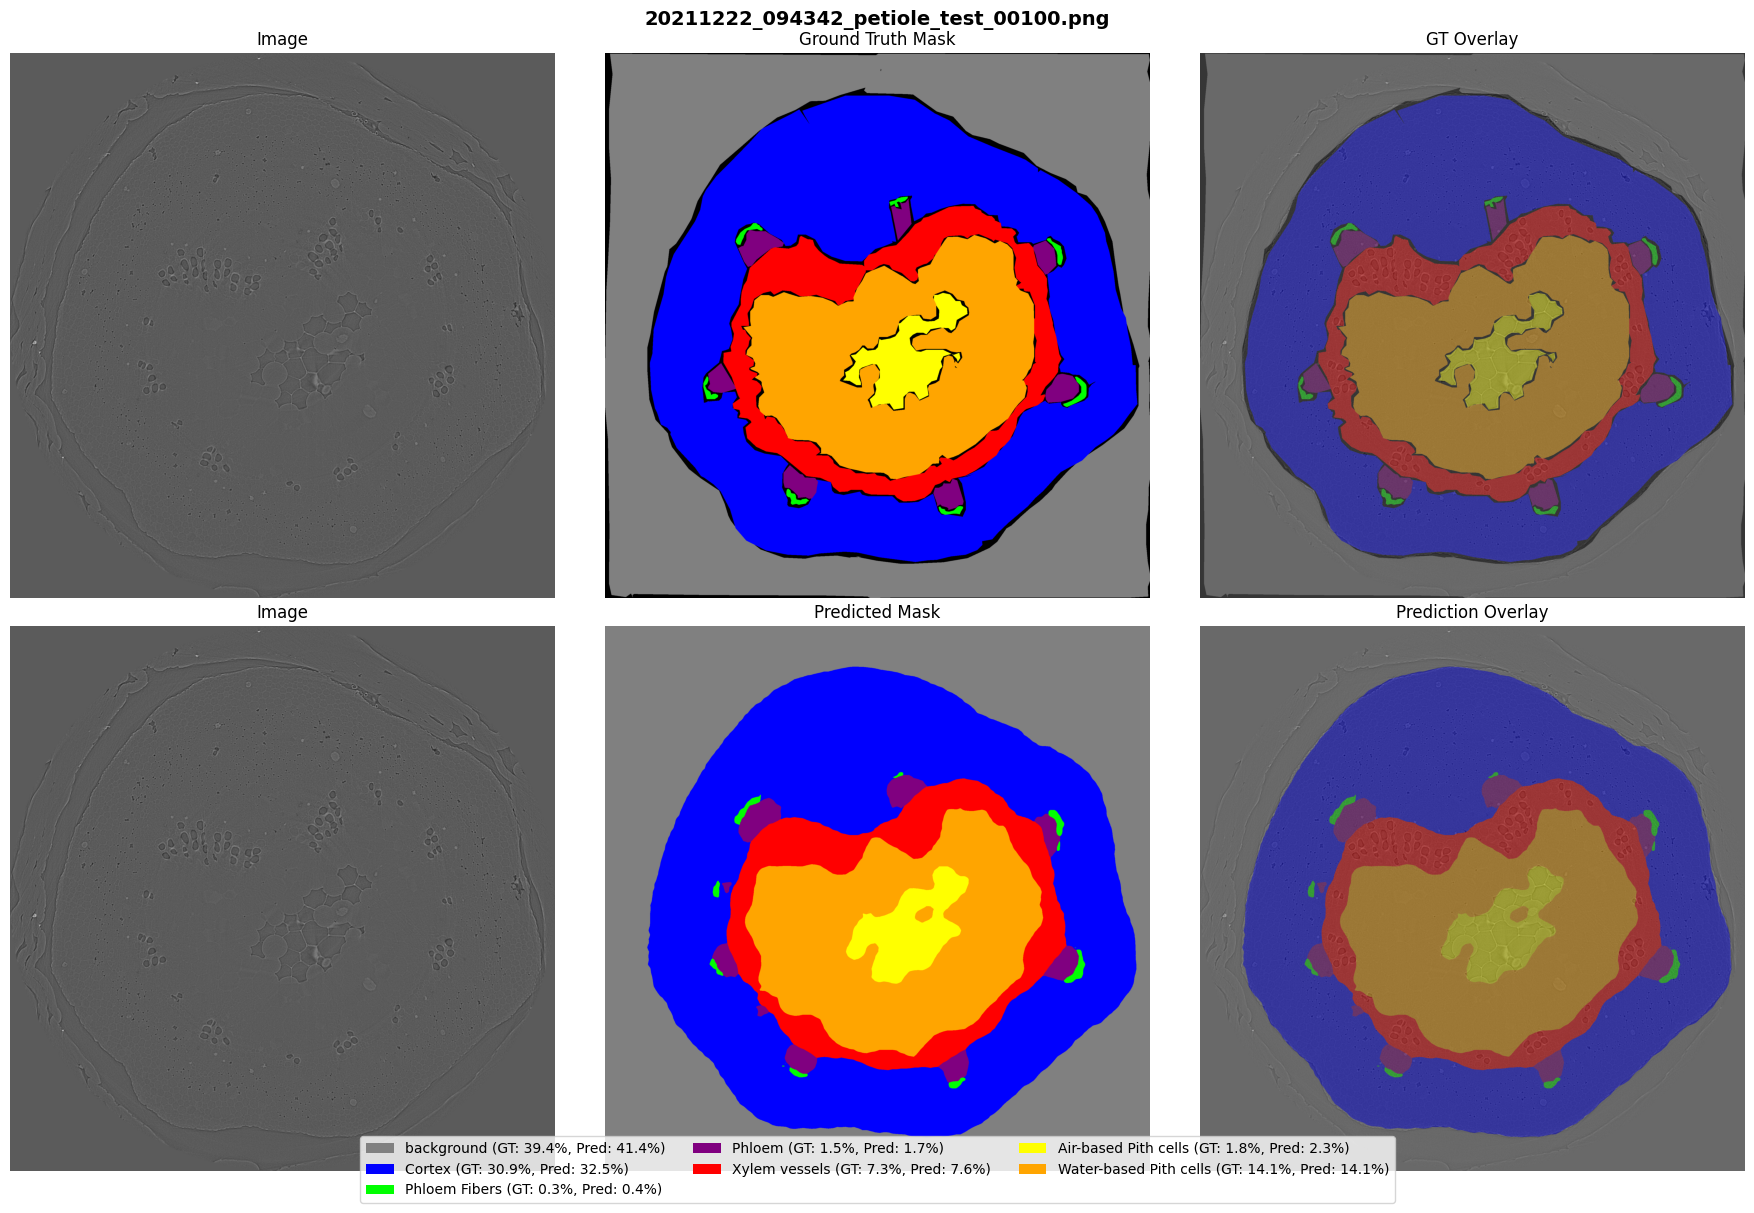

----------------------------------------------------------------------
20211222_094342_petiole_test_00400.png
  GT classes: [  0   1   2   3   4   5   6 255]
  Predicted classes: [0 1 2 3 4 5 6]


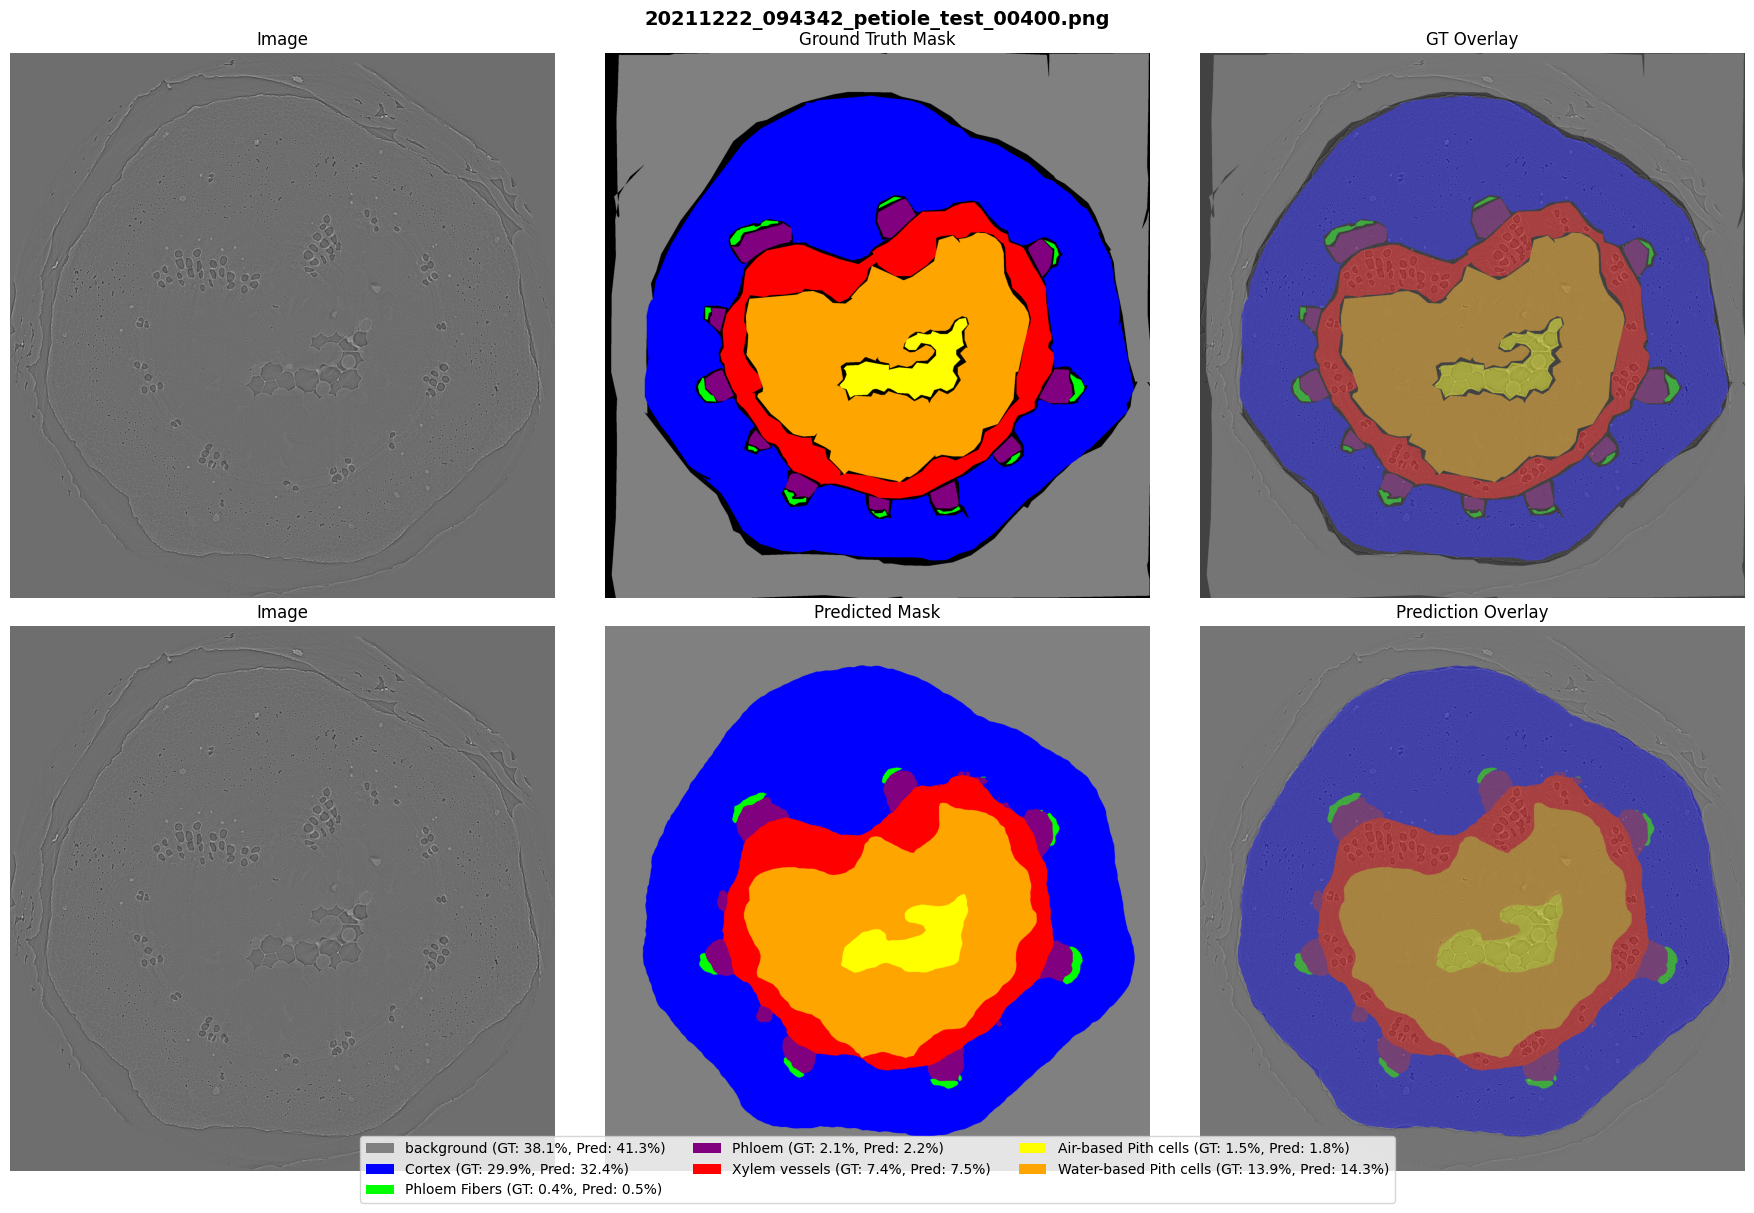

----------------------------------------------------------------------
20211222_113313_petiole3_00400.png
  GT classes: [  1   2   3   4   5   6 255]
  Predicted classes: [0 1 2 3 4 5 6]


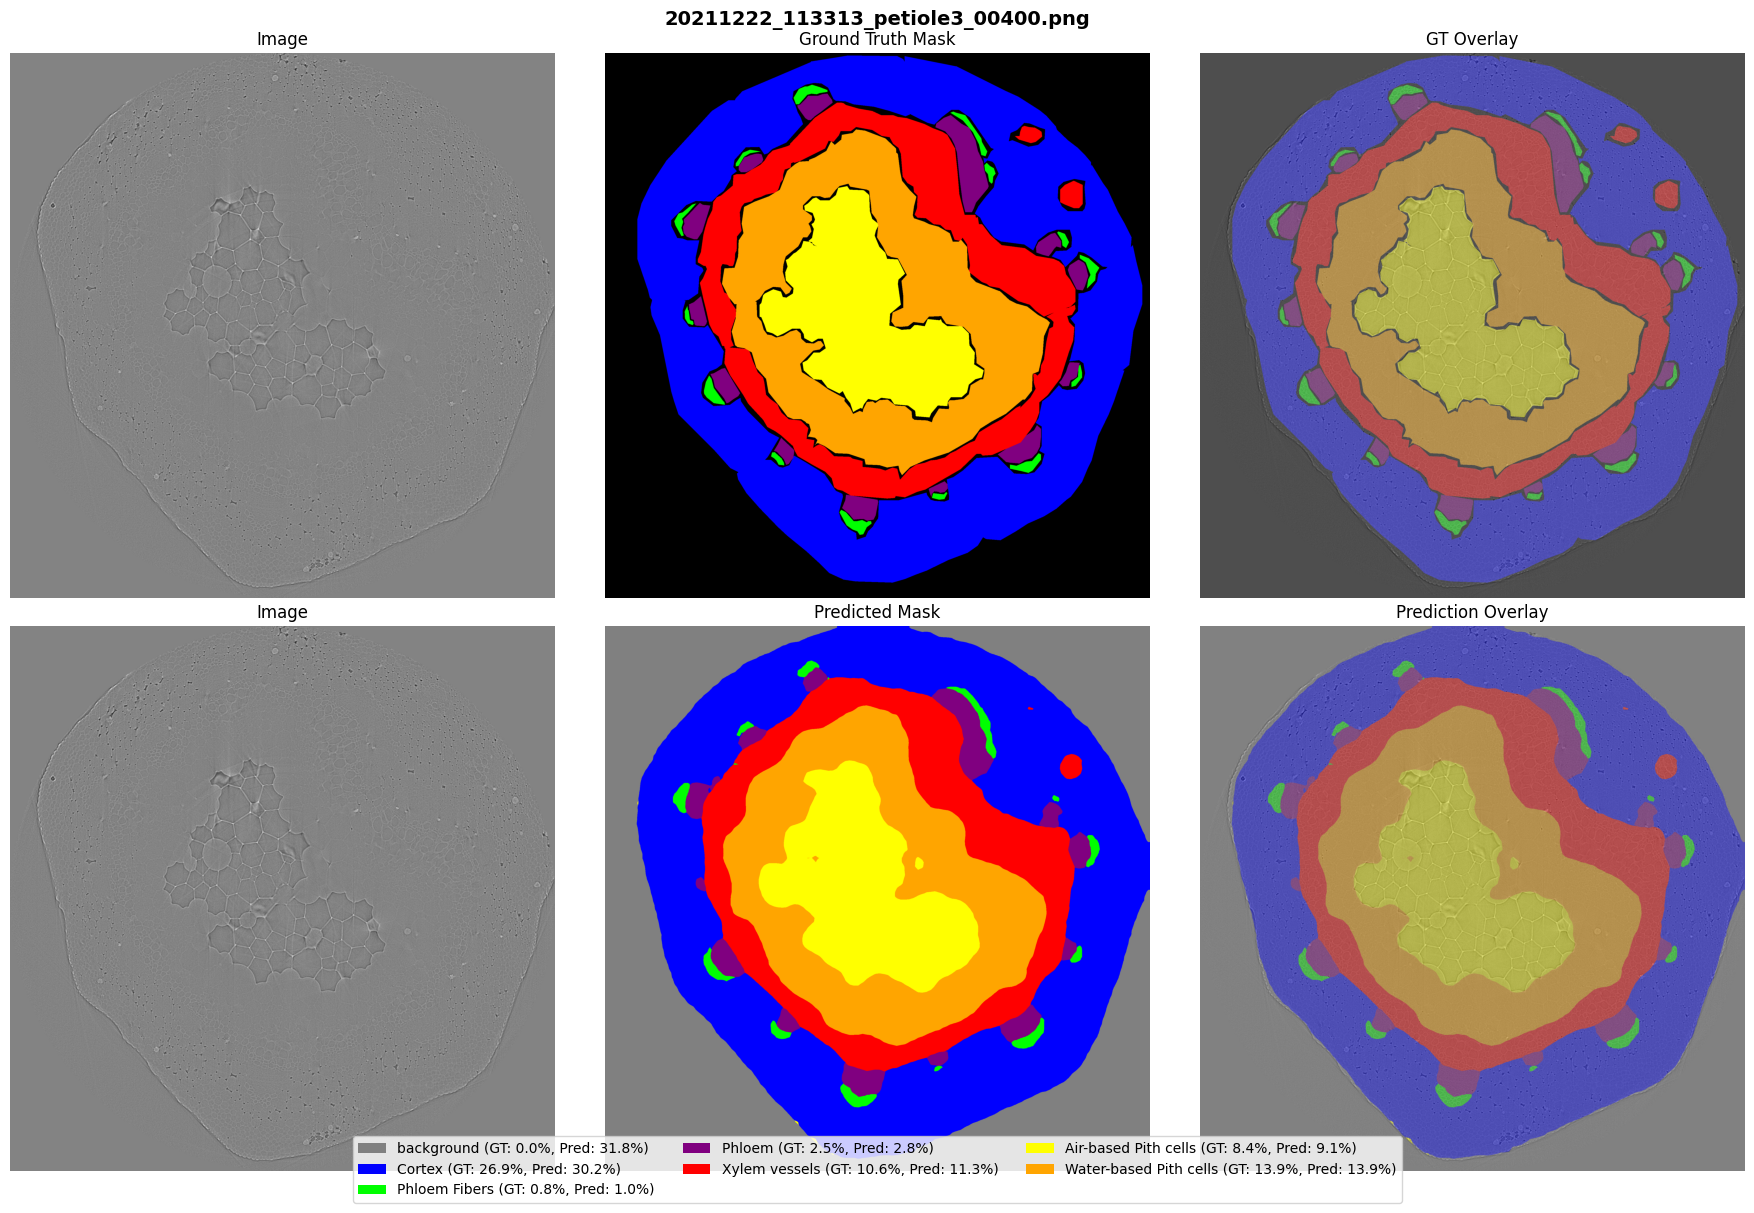

----------------------------------------------------------------------
20211222_125057_petiole4_00400.png
  GT classes: [  0   1   2   3   4   5   6 255]
  Predicted classes: [0 1 2 3 4 5 6]


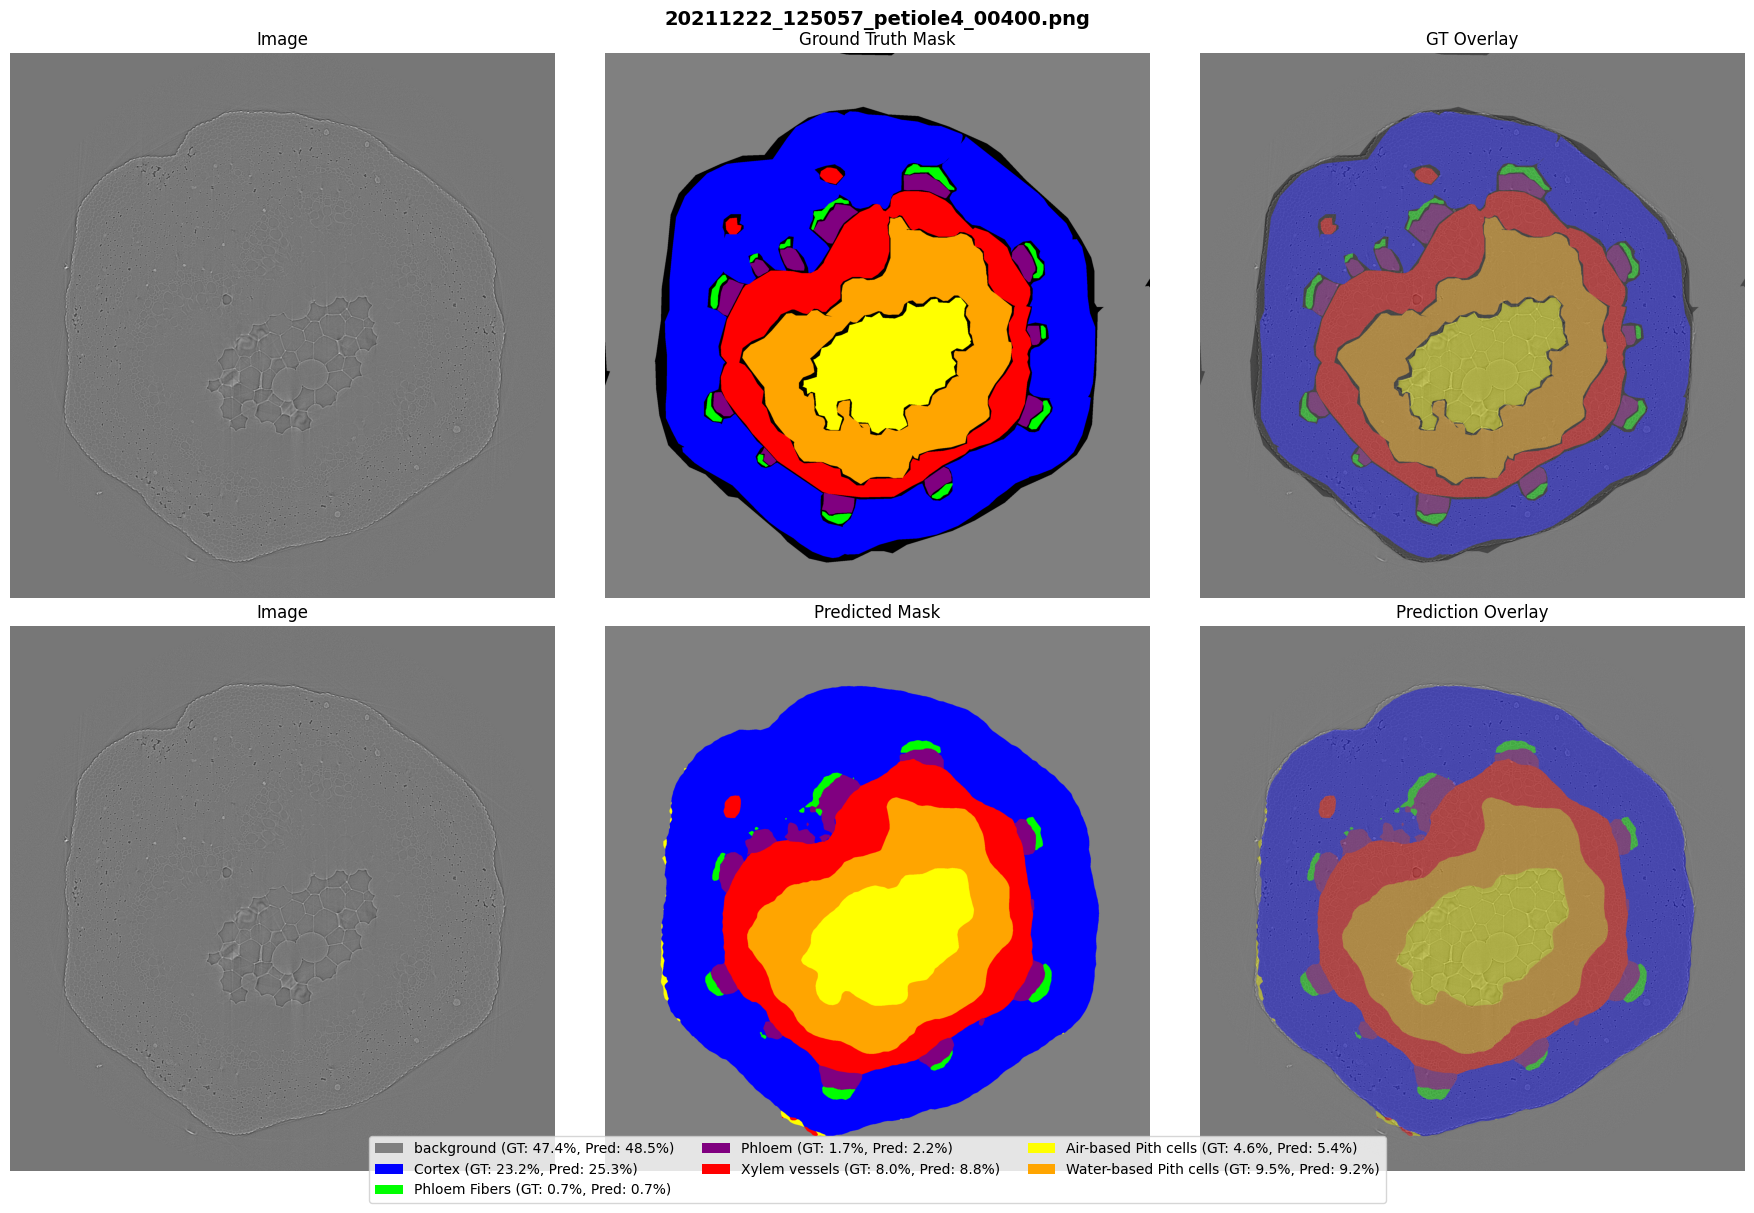

----------------------------------------------------------------------


In [2]:
import lightly_train
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# ------------------------
# Class definitions
# ------------------------
CLASS_COLORS = {
    0: [128,128,128],    # gray - background
    1: [0, 0, 255],      # Blue - Cortex
    2: [0, 255, 0],      # Green - Phloem Fibers
    3: [128, 0, 128],    # Purple - Phloem
    4: [255, 0, 0],      # Red - Xylem vessels
    5: [255, 255, 0],    # Yellow - Air-based Pith cells
    6: [255, 165, 0],    # Orange - Water-based Pith cells
}

CLASS_NAMES = {
    0: "background",
    1: "Cortex",
    2: "Phloem Fibers",
    3: "Phloem",
    4: "Xylem vessels",
    5: "Air-based Pith cells",
    6: "Water-based Pith cells",
}

# Ignored classes (shown in black)
IGNORE_CLASSES = [255]

def mask_to_color(mask_array):
    """
    Convert a grayscale mask to RGB using class colors.
    Ignored classes (0, 255) are shown in black.
    
    Args:
        mask_array: 2D numpy array with class indices
    
    Returns:
        RGB image as numpy array
    """
    h, w = mask_array.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    
    for class_id, color in CLASS_COLORS.items():
        color_mask[mask_array == class_id] = color
    
    # Ignored classes remain black (0, 0, 0)
    
    return color_mask

# ------------------------
# Paths
# ------------------------
IMG_DIR = Path("/pscratch/sd/x/xchong/lightly/4folders_png/val/images")
MASK_DIR = Path("/pscratch/sd/x/xchong/lightly/4folders_png/val/masks")
CKPT_PATH = "/pscratch/sd/x/xchong/lightly/out_png/my_experiment_4folders_3/checkpoints/best.ckpt"

# ------------------------
# Load model
# ------------------------
model = lightly_train.load_model(CKPT_PATH)
model.eval()

# ------------------------
# Supported image formats
# ------------------------
IMG_EXTS = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}

# ------------------------
# Inference + plot loop
# ------------------------
with torch.inference_mode():
    for img_path in sorted(IMG_DIR.iterdir()):
        if img_path.suffix.lower() not in IMG_EXTS:
            continue
        
        # Find corresponding ground truth mask
        mask_path = MASK_DIR / img_path.name
        if not mask_path.exists():
            print(f"Warning: No ground truth mask found for {img_path.name}")
            continue
        
        # Load image
        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)
        
        # Load ground truth mask
        gt_mask = Image.open(mask_path)
        gt_mask_np = np.array(gt_mask)
        
        # Predict mask
        pred_mask = model.predict(str(img_path))
        
        # Convert prediction mask safely
        if isinstance(pred_mask, torch.Tensor):
            pred_mask_np = pred_mask.detach().cpu().numpy()
        else:
            pred_mask_np = np.array(pred_mask)
        
        # Get unique classes from both masks
        gt_unique = np.unique(gt_mask_np)
        pred_unique = np.unique(pred_mask_np)
        all_unique = np.unique(np.concatenate([gt_unique, pred_unique]))
        active_classes = [c for c in all_unique if c not in IGNORE_CLASSES]
        
        print(f"{img_path.name}")
        print(f"  GT classes: {gt_unique}")
        print(f"  Predicted classes: {pred_unique}")
        
        # Convert masks to color
        gt_color_mask = mask_to_color(gt_mask_np)
        pred_color_mask = mask_to_color(pred_mask_np)
        
        # Create overlays
        gt_overlay = (0.6 * img_np + 0.4 * gt_color_mask).astype(np.uint8)
        pred_overlay = (0.6 * img_np + 0.4 * pred_color_mask).astype(np.uint8)
        
        # ------------------------
        # Plot (TWO ROWS)
        # ------------------------
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Row 1: Ground Truth
        axes[0, 0].imshow(img_np)
        axes[0, 0].axis("off")
        axes[0, 0].set_title("Image")
        
        axes[0, 1].imshow(gt_color_mask)
        axes[0, 1].axis("off")
        axes[0, 1].set_title("Ground Truth Mask")
        
        axes[0, 2].imshow(gt_overlay)
        axes[0, 2].axis("off")
        axes[0, 2].set_title("GT Overlay")
        
        # Row 2: Prediction
        axes[1, 0].imshow(img_np)
        axes[1, 0].axis("off")
        axes[1, 0].set_title("Image")
        
        axes[1, 1].imshow(pred_color_mask)
        axes[1, 1].axis("off")
        axes[1, 1].set_title("Predicted Mask")
        
        axes[1, 2].imshow(pred_overlay)
        axes[1, 2].axis("off")
        axes[1, 2].set_title("Prediction Overlay")
        
        # Add legend for active classes
        legend_elements = []
        for class_id in sorted(active_classes):
            if class_id in CLASS_COLORS:
                color = np.array(CLASS_COLORS[class_id]) / 255.0
                name = CLASS_NAMES.get(class_id, f"Class {class_id}")
                
                # Count pixels in both masks
                gt_count = np.sum(gt_mask_np == class_id)
                pred_count = np.sum(pred_mask_np == class_id)
                gt_pct = gt_count / gt_mask_np.size * 100
                pred_pct = pred_count / pred_mask_np.size * 100
                
                label = f"{name} (GT: {gt_pct:.1f}%, Pred: {pred_pct:.1f}%)"
                legend_elements.append(plt.Rectangle((0, 0), 1, 1, fc=color, label=label))
        
        if legend_elements:
            fig.legend(handles=legend_elements, loc='lower center', 
                      ncol=min(3, len(legend_elements)), bbox_to_anchor=(0.5, -0.02))
        
        plt.suptitle(img_path.name, fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print("-" * 70)